In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nbn = "03_" # Notebook Number; Prefix for artifacts path

In [2]:
datasets = ["DTD","SVHN","Caltech256","SUN397","iWildCam","iWildCamID","CIFAR10","CINIC10"] # GTSRB, MNIST, EuroSAT
test_dypes = ["InD","InD","InD","InD","OOD","InD","InD","OOD"] # GTSRB, MNIST, EuroSAT
nrow, ncol=2, 4
pred_prefix = "csv/prediction_"
unc_prefix = "csv/uncertainty_"

In [3]:
def calc_tpr(targ, pred):
    tp = np.sum((targ == 1) & (pred == 1))
    fn = np.sum((targ == 1) & (pred == 0))
    overall_p = np.sum(targ == 1)
    if overall_p==0:
        print("no cases where Target==1, likely an error has occured.")
        overall_p=1
    return tp / overall_p
def calc_fpr(targ, pred):
    fp = np.sum((targ == 0) & (pred == 1))
    tn = np.sum((targ == 0) & (pred == 0))
    overall_n = np.sum(targ == 0)
    return fp / overall_n
def predict_correctness(ent_ls,threshold):
    return np.where(ent_ls>=threshold,0,1)

In [4]:
def auroc(pred_vec, target_vec, unc_vec, label, steps, ax):
    cor_pred = np.where(pred_vec == target_vec, 1, 0)
    max_unc = unc_vec.max()
    min_unc = unc_vec.min()
    if(max_unc>10000 or min_unc<-10000):
        print("Warning: numerical stability issue encountered.")
    tpr = np.array([]) 
    fpr = np.array([])
    in_ls = ((int)(len(unc_vec)/(steps+1)))*np.arange(steps+1)
    perc_ls = np.append(np.sort(unc_vec)[in_ls],max_unc+1)
    for ent_step in perc_ls:
        temp = predict_correctness(unc_vec, ent_step)
        tpr = np.append(tpr, calc_tpr(cor_pred, temp))
        fpr = np.append(fpr, calc_fpr(cor_pred, temp))
    area = np.trapz(tpr, fpr)
    # sns.lineplot(x=fpr, y=tpr, label=f"{label} (AUC: {area:.2f})", x)
    ax.plot(fpr, tpr, label=f"{label} (AUC: {area:.2f})")
    return area

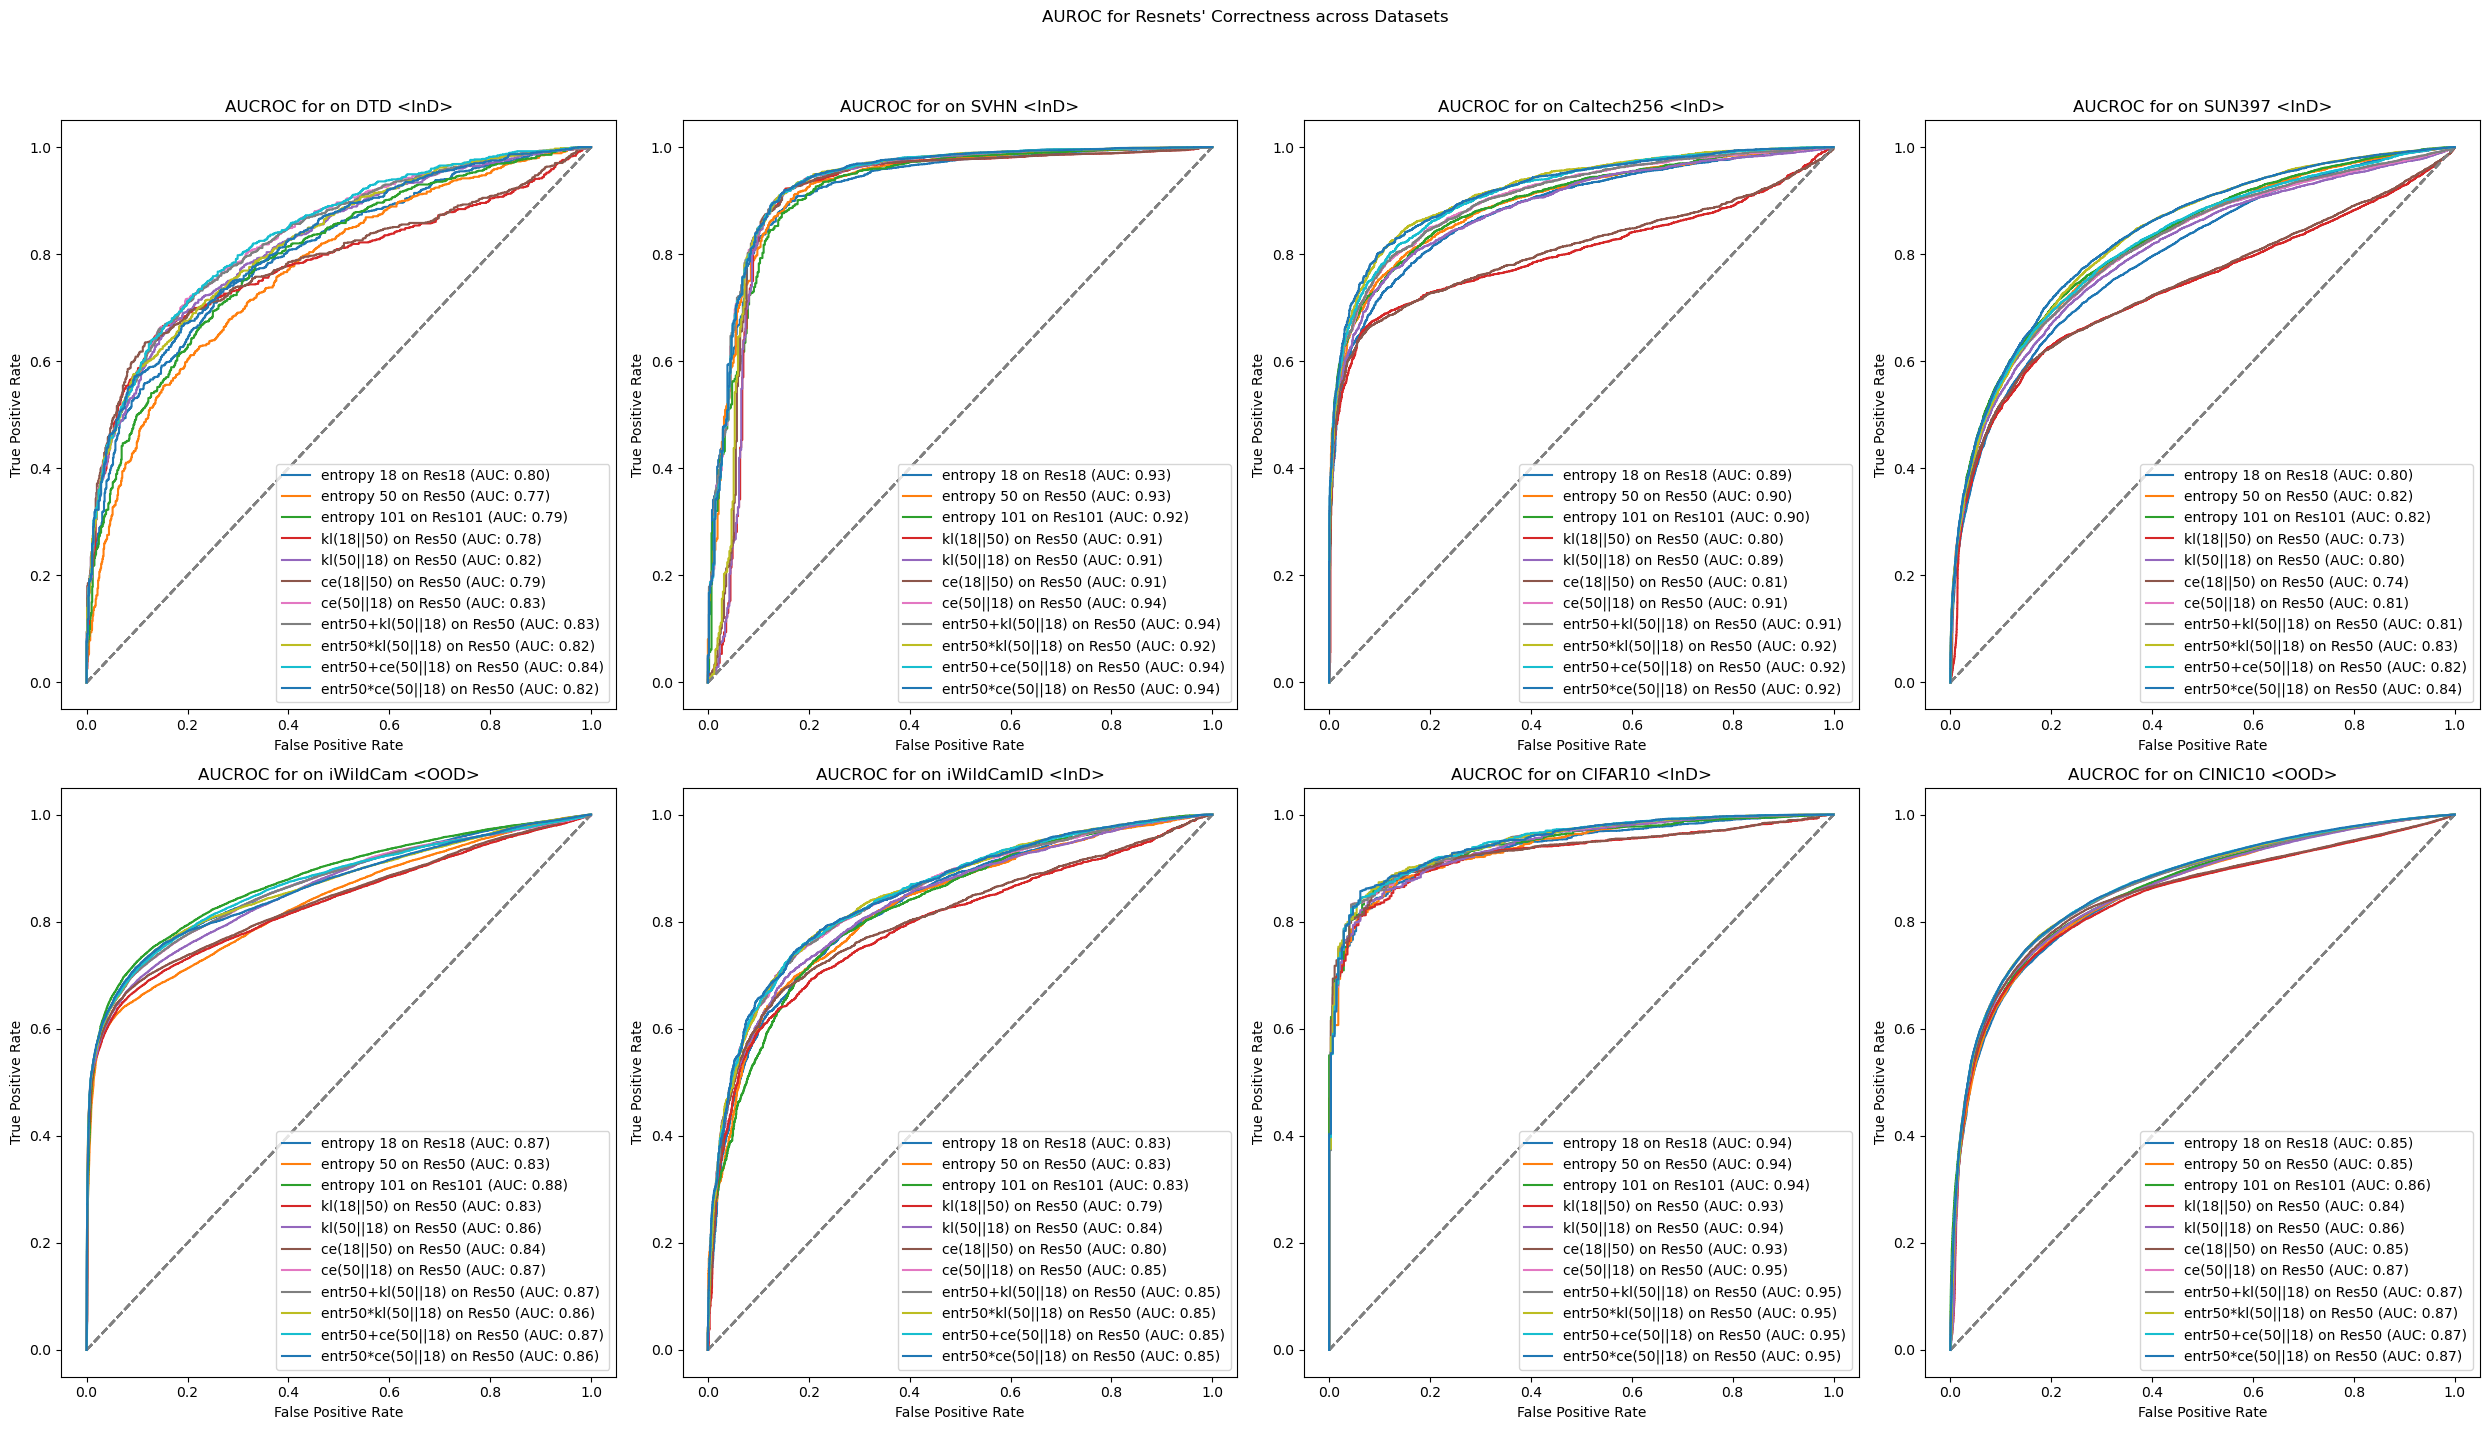

In [5]:
fig, axes = plt.subplots(nrow, ncol, figsize=(25, 15))
steps = 200

for i, ds in enumerate(datasets):
    pred = pd.read_csv(f"{pred_prefix}{ds}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_prefix}{ds}.csv", index_col="Unnamed: 0")
    
    metrics = [
        (unc_pred["ent_18"], "entropy 18 on Res18", "pred18"),
        (unc_pred["ent_50"], "entropy 50 on Res50", "pred50"),
        (unc_pred["ent_101"], "entropy 101 on Res101", "pred101"),  
        (unc_pred["kl_18_50"], "kl(18||50) on Res50", "pred50"),
        (unc_pred["kl_50_18"], "kl(50||18) on Res50", "pred50"),
        
        # (unc_pred["kl_18_101"], "kl(18||101) on Res101", "pred101"),
        # (unc_pred["kl_101_18"], "kl(101||18) on Res101", "pred101"),
        (unc_pred["ce_18_50"], "ce(18||50) on Res50", "pred50"),
        (unc_pred["ce_50_18"], "ce(50||18) on Res50", "pred50"),
        # (unc_pred["ce_18_101"], "ce(18||101) on Res101", "pred101"),
        # (unc_pred["ce_101_18"], "ce(101||18) on Res101", "pred101"),
        (unc_pred["ent_50"] + unc_pred["kl_50_18"], "entr50+kl(50||18) on Res50", "pred50"),
        (unc_pred["ent_50"] * unc_pred["kl_50_18"], "entr50*kl(50||18) on Res50", "pred50"),
        # (unc_pred["ent_18"] * unc_pred["kl_18_50"], "entr18*kl(18||50) on Res50", "pred50"),
        (unc_pred["ent_50"] + unc_pred["ce_50_18"], "entr50+ce(50||18) on Res50", "pred50"),
        (unc_pred["ent_50"] * unc_pred["ce_50_18"], "entr50*ce(50||18) on Res50", "pred50")
    ]
    steps = pred.shape[0]-1
    ax = axes[i // ncol, i % ncol]
    for metric, label, pred_on in metrics:
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
        auroc(pred[pred_on], pred["target"], metric, label, steps, ax)
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title(f"AUCROC for on {ds} <{test_dypes[i]}>")
        ax.legend(loc="lower right")

plt.suptitle(f"AUROC for Resnets' Correctness across Datasets")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f"artifacts/{nbn}aucroc.png")
plt.show()